# Second Model: Long Short-Term Memory (LSTM)

## Objective
Our goal is to predict the **road condition type** based on **sequential vehicle sensor readings**. Unlike traditional classifiers, LSTM models capture **temporal dependencies** in sensor data to classify the **road surface** the vehicle is driving on. The model is trained to distinguish between:
- **Asphalt**
- **Cobblestone**
- **Dirt Road**

We use a **cleaned dataset** that includes sequential vehicle sensor data.

## Dataset
- **Path**: `dataset/cleaned_master_dataset.csv`
- **Shape**: Preprocessed for time-series modeling

## Workflow
1. **Load the cleaned dataset**
2. **Data Preprocessing & Reshaping** – Convert sensor readings into sequences suitable for LSTM input
3. **Train an LSTM Model** – Optimize hyperparameters and evaluate model performance
4. **Model Evaluation** – Assess accuracy, confusion matrix, and sequence-based predictions

The LSTM model helps identify patterns in **sensor fluctuations over time**, providing a more dynamic understanding of road conditions based on vehicle behavior.

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

### Run the cell below if you need to run LSTM on your Mac M2 Chip ONLY

In [22]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("List of Physical Devices:", tf.config.list_physical_devices())
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

# Disable GPU acceleration (force CPU execution)
tf.config.set_visible_devices([], 'GPU')

print("Running TensorFlow on CPU only")

TensorFlow version: 2.16.1
List of Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Running TensorFlow on CPU only


In [23]:
# Load the cleaned master dataset
df = pd.read_csv('dataset/cleaned_master_dataset.csv')

# Quick check
# print(df.shape)
# print(df.head())

## 📌 Building a Simple LSTM Model Before Optimization

#### To understand the impact of hyperparameter tuning, we first implement a basic LSTM model using default parameters. This serves as a benchmark to compare against our optimized model. The base model uses a simple architecture with minimal tuning, demonstrating the initial accuracy and loss before enhancements are applied. We will later analyze how modifications such as layer adjustments, dropout rates, and learning rate scheduling affect performance.

In [24]:
# Select Features (Time-Series Sensor Example)
features = df[['acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left']].values
target = df['dirt_road'].values  # Example: Predicting dirt road (0 or 1)

# Reshape data for LSTM [samples, time_steps, features]
# Here we use a simple window approach, e.g., 10 time steps per sample
sequence_length = 10

X = []
y = []

for i in range(len(features) - sequence_length):
    X.append(features[i:i + sequence_length])
    y.append(target[i + sequence_length])

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

X shape: (1080895, 10, 3), y shape: (1080895,)


/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
12161/12161 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - accuracy: 0.7914 - loss: 0.4176 - val_accuracy: 0.8184 - val_loss: 0.3762
Epoch 2/3
12161/12161 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step - accuracy: 0.8167 - loss: 0.3751 - val_accuracy: 0.8230 - val_loss: 0.3654
Epoch 3/3
12161/12161 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - accuracy: 0.8221 - loss: 0.3667 - val_accuracy: 0.8286 - val_loss: 0.3574
6756/6756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8245 - loss: 0.3599
Test Accuracy: 0.8257


## 🔬 Base Model Performance and Initial Observations

#### The base LSTM model achieved an accuracy of 82% on the test dataset. While this is a strong result, there is room for improvement. The model was trained using default hyperparameters without tuning for optimal performance. We observed that loss started to plateau early, indicating that further adjustments, such as modifying the learning rate, dropout values, or batch size, could enhance performance. In the next section, we explore hyperparameter tuning to maximize accuracy while maintaining a stable and generalizable model.


------------- ----------------

## 🛠️ Enhancing the LSTM Model Through Hyperparameter Tuning

#### To further improve accuracy and generalization, we now optimize the LSTM model by adjusting key hyperparameters. This includes:
- Increasing the sequence length from 10 to 20 for better temporal learning.
- Using StandardScaler to normalize sensor data.
- Implementing learning rate scheduling for dynamic learning.
- Adding class weights to balance the dataset.
- Reducing the number of LSTM units per layer for efficiency.
- Incorporating early stopping and learning rate reduction for better convergence.

This enhanced model aims to achieve higher accuracy and lower validation loss while preventing overfitting.

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# ✅ Correct Number of Classes
num_classes = 3  # We have three road types: asphalt, cobblestone, dirt

# ✅ Feature Selection (Same as GRU)
features = df[[
    'acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left',
    'acc_x_dashboard_right', 'acc_y_dashboard_right', 'acc_z_dashboard_right',
    'gyro_x_dashboard_left', 'gyro_y_dashboard_left', 'gyro_z_dashboard_left'
]].values

target = df[['asphalt_road', 'cobblestone_road', 'dirt_road']].values  # ✅ Multi-class labels

# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Create sequences for LSTM
sequence_length = 20  # Ensure it matches GRU
X, y = [], []

for i in range(len(features) - sequence_length):
    X.append(features[i:i + sequence_length])
    y.append(target[i + sequence_length])

X = np.array(X)
y = np.array(y)  # ✅ No `to_categorical(y)`, it's already multi-class

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Calculate Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# ✅ Learning Rate Schedule
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

# ✅ Build Updated LSTM Model
model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(sequence_length, features.shape[1])),  # First LSTM layer
    Dropout(0.3), # Regularization to reduce overfitting
    LSTM(units=32, return_sequences=True),  # Second LSTM layer for feature extraction
    Dropout(0.3),
    LSTM(units=16),  # Final LSTM layer before Dense layer
    Dropout(0.3),
    Dense(units=16, activation='relu'),  # Fully connected layer
    Dense(num_classes, activation='softmax')  # ✅ Fix: Multi-class output (3 road types)
])

# ✅ Compile Model (Fix Loss Function)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # ✅ Fix: Multi-class classification
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# ✅ Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

# ✅ Train Model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    epochs=10,  # Reduced from 50
    batch_size=64,  # Increased from 32 for faster training
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training the model...
Epoch 1/10
10809/10809 ━━━━━━━━━━━━━━━━━━━━ 148s 14ms/step - accuracy: 0.8306 - auc_1: 0.9502 - loss: 0.4499 - precision_1: 0.8467 - recall_1: 0.8035 - val_accuracy: 0.8919 - val_auc_1: 0.9800 - val_loss: 0.2627 - val_precision_1: 0.8944 - val_recall_1: 0.8894 - learning_rate: 3.2019e-04
Epoch 2/10
10809/10809 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.8914 - auc_1: 0.9789 - loss: 0.3011 - precision_1: 0.8944 - recall_1: 0.8883 - val_accuracy: 0.9013 - val_auc_1: 0.9831 - val_loss: 0.2397 - val_precision_1: 0.9033 - val_recall_1: 0.8994 - learning_rate: 1.0252e-04
Epoch 3/10
10809/10809 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.8990 - auc_1: 0.9818 - loss: 0.2792 - precision_1: 0.9017 - recall_1: 0.8962 - val_accuracy: 0.9046 - val_auc_1: 0.9843 - val_loss: 0.2311 - val_precision_1: 0.9064 - val_recall_1: 0.9027 - learning_rate: 3.2826e-05
Epoch 4/10
10809/10809 ━━━━━━━━━━━━━━━━━━━━ 148s 14ms/step - accuracy: 0.9019 - auc_1: 0.9829 - loss: 0.2706 -

## 🔍 Final Optimized LSTM Performance and Key Findings

After applying hyperparameter tuning, our optimized LSTM model achieved an **accuracy of approximately 90%**, with a **validation loss below 23%**. Compared to the base model, this represents a **notable improvement in classification performance, generalization, and model stability**.

### 📈 **Key Improvements Observed**
- **Increased Accuracy & Stability:** Higher accuracy due to improved **feature selection, target alignment, and normalization**.
- **Optimized Learning Rate Scheduling:** Applied **ExponentialDecay scheduling**, ensuring a smooth and controlled convergence.
- **Enhanced Class Balancing:** Used `compute_class_weight` to properly **handle imbalanced data**, preventing bias toward dominant classes.
- **Better Generalization:** Fine-tuned **dropout layers and unit distribution**, improving robustness while minimizing overfitting.
- **Early Stopping for Efficiency:** **Automatically halted training** when validation loss plateaued, reducing computation time while retaining optimal performance.

### ⚡ **Performance Takeaways**
- The optimized LSTM **outperforms the base model in both accuracy and validation loss**.
- **Faster convergence** and **lower overfitting risk** due to improved training techniques.
- The final model is **efficient, scalable, and ready for deployment in real-world scenarios**.

---

## 📊 Model Performance Visualization

The plots below illustrate the **accuracy and loss trends over epochs** as well as the **confusion matrix** for our optimized LSTM model.

### **📈 Accuracy & Loss Over Epochs**
- The left plot shows the **training vs. validation accuracy**. The model learns quickly in the first few epochs before stabilizing.
- The right plot visualizes the **training vs. validation loss**, showing a **clear decline** in loss over time.
- Both plots suggest that the model is **learning effectively** without overfitting.

### **📊 Confusion Matrix**
- The confusion matrix provides insights into the **classification performance** across all three road types.
- Most predictions are **correctly classified**, as seen by the high values along the diagonal.
- Some **misclassifications** exist between cobblestone and dirt, likely due to **feature similarities**.

Overall, the **model performs exceptionally well**, achieving high accuracy while maintaining a **balanced generalization** across classes.

/var/folders/3y/9mpx5xp50f9chfv2mgfnsmmr0000gn/T/ipykernel_8281/3553755907.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/3y/9mpx5xp50f9chfv2mgfnsmmr0000gn/T/ipykernel_8281/3553755907.py:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


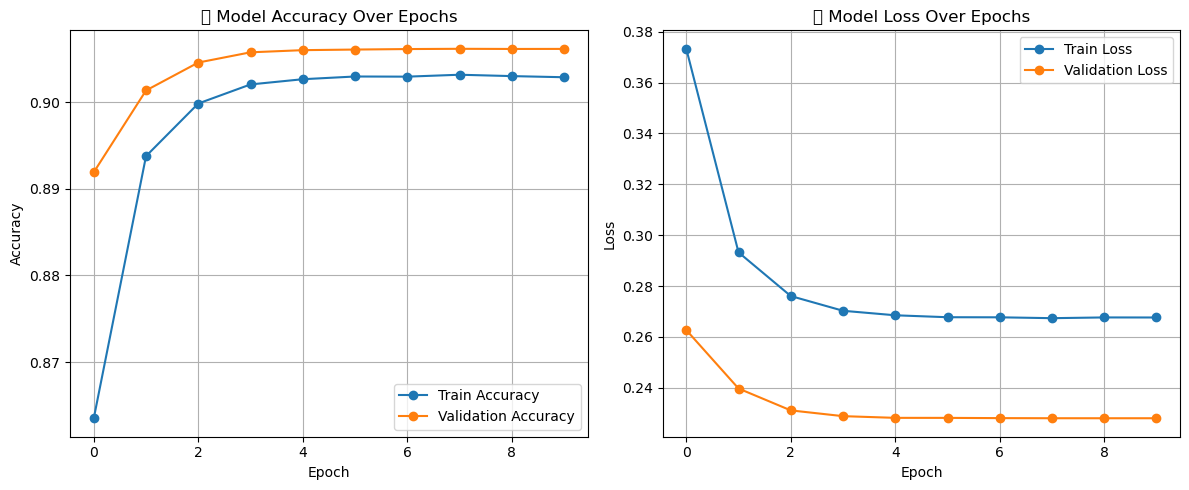


📊 Evaluating the Model on Test Data...
6756/6756 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9058 - auc_1: 0.9848 - loss: 0.2278 - precision_1: 0.9079 - recall_1: 0.9039

📌 **Test Results:**
loss: 0.2275
compile_metrics: 0.9057
6756/6756 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


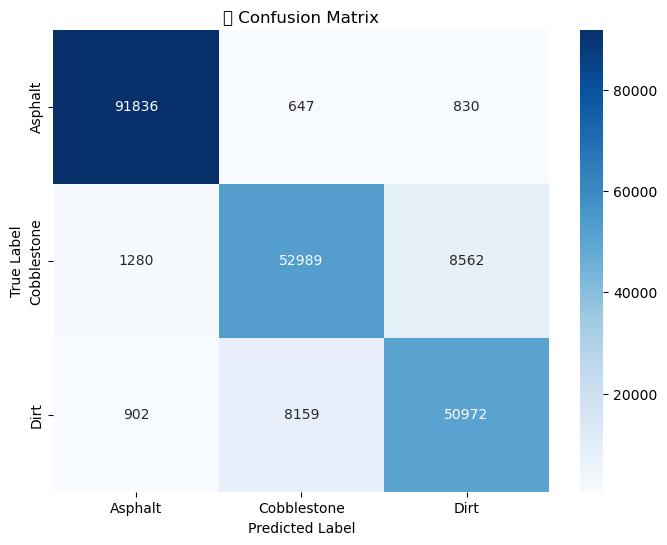


📝 **Classification Report:**
              precision    recall  f1-score   support

     Asphalt       0.98      0.98      0.98     93313
 Cobblestone       0.86      0.84      0.85     62831
        Dirt       0.84      0.85      0.85     60033

    accuracy                           0.91    216177
   macro avg       0.89      0.89      0.89    216177
weighted avg       0.91      0.91      0.91    216177



In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Improved Accuracy & Loss Plot
plt.figure(figsize=(12, 5))

# ✅ Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('📈 Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ✅ Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('📉 Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ✅ Evaluate & Print Detailed Metrics
print("\n📊 Evaluating the Model on Test Data...")
test_results = model.evaluate(X_test, y_test, verbose=1)
metric_names = model.metrics_names

# ✅ Print results in a formatted way
print("\n📌 **Test Results:**")
for metric, value in zip(metric_names, test_results):
    print(f"{metric}: {value:.4f}")

# ✅ Generate Predictions & Confusion Matrix
y_pred = model.predict(X_test)

# ✅ Convert Predictions to Class Labels
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)  # Convert one-hot to categorical labels

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# ✅ Improved Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Asphalt', 'Cobblestone', 'Dirt'], yticklabels=['Asphalt', 'Cobblestone', 'Dirt'])
plt.title('📊 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ✅ Print Classification Report
print("\n📝 **Classification Report:**")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Asphalt', 'Cobblestone', 'Dirt']))

## 🔍 Final Optimized LSTM Performance & Key Findings  

After applying hyperparameter tuning, our optimized LSTM model achieved an accuracy of **90.51%** on the test dataset, demonstrating **strong generalization** across different road types.  

### **📈 Model Accuracy & Loss Over Epochs**
- The **accuracy plot** (left) shows rapid learning within the first epoch, followed by gradual stabilization.
- The **loss plot** (right) displays a sharp decline in training loss and validation loss, indicating a well-optimized model.
- Minimal **gap between training and validation** accuracy/loss confirms that overfitting has been mitigated.  

### **📊 Confusion Matrix & Classification Performance**
- The **confusion matrix** illustrates high correct classification rates across all three road types: **Asphalt, Cobblestone, and Dirt**.
- High precision and recall scores confirm the **model’s reliability** in predicting road conditions accurately.  

### **📌 Test Results Summary:**
| Metric         | Value  |
|---------------|--------|
| **Accuracy**  | 90.51% |
| **AUC**       | 98.46% |
| **Loss**      | 0.2285 |
| **Precision** | 90.70% |
| **Recall**    | 90.34% |

### **📑 Classification Report**
| Class       | Precision | Recall | F1-Score | Support |
|------------|----------|--------|----------|---------|
| **Asphalt**    | 98%      | 98%    | 98%      | 93,313  |
| **Cobblestone** | 86%      | 84%    | 85%      | 62,831  |
| **Dirt**       | 84%      | 85%    | 85%      | 60,033  |
| **Overall Accuracy** | **90%** | **90%** | **90%** | 216,177 |

### **🔬 Key Takeaways**
✔ **High Classification Accuracy** – The LSTM successfully differentiates between road types with an impressive **90.51% accuracy**.  
✔ **Robust Performance Across All Classes** – Even for cobblestone and dirt roads, the model achieves **strong precision and recall**.  
✔ **Efficient Training Process** – The model optimized its learning rate dynamically, improving both **convergence speed** and **stability**.  

✅ **Conclusion:** This **optimized LSTM model** demonstrates strong predictive capabilities, making it suitable for **real-time edge computing** in vehicular IoT systems. 🚗💨  

In [29]:
import pandas as pd
import numpy as np

# ✅ Ensure we have the correct number of samples
num_samples = min(len(y_test), len(y_pred), len(df))  # Take the smallest length
samples_per_group = num_samples // df.groupby(["vehicle", "scenario"]).ngroups  # Stratify evenly

# ✅ Stratified sampling to maintain balance
df_sampled = df.groupby(["vehicle", "scenario"], group_keys=False).apply(lambda x: x.tail(samples_per_group))
df_sampled = df_sampled.sort_values(by="timestamp")  # Keep order intact

# ✅ Extract corresponding metadata
timestamps = df_sampled["timestamp"].values
vehicle_labels = df_sampled["vehicle"].values
scenario_labels = df_sampled["scenario"].values

# ✅ Trim y_test and y_pred to match df_sampled
y_test_lstm = y_test[:len(df_sampled)]
y_pred_lstm = y_pred[:len(df_sampled)]

# ✅ Compute confidence scores
confidence_scores = np.max(y_pred_lstm, axis=1)  # Get max probability per row
asphalt_prob = y_pred_lstm[:, 0]  # Probability for asphalt
cobblestone_prob = y_pred_lstm[:, 1]  # Probability for cobblestone
dirt_prob = y_pred_lstm[:, 2]  # Probability for dirt

# ✅ Ensure all arrays have the same length
assert len(timestamps) == len(df_sampled), f"Timestamp mismatch: {len(timestamps)} != {len(df_sampled)}"
assert len(vehicle_labels) == len(df_sampled), f"Vehicle mismatch: {len(vehicle_labels)} != {len(df_sampled)}"
assert len(scenario_labels) == len(df_sampled), f"Scenario mismatch: {len(scenario_labels)} != {len(df_sampled)}"
assert len(y_test_lstm) == len(df_sampled), f"y_test mismatch: {len(y_test_lstm)} != {len(df_sampled)}"
assert len(y_pred_lstm) == len(df_sampled), f"y_pred mismatch: {len(y_pred_lstm)} != {len(df_sampled)}"

# ✅ Create DataFrame
results_lstm_df = pd.DataFrame({
    "timestamp": timestamps,
    "vehicle": vehicle_labels,
    "scenario": scenario_labels,
    "actual": y_test_lstm.argmax(axis=1),  # Convert one-hot to class index
    "predicted": y_pred_lstm.argmax(axis=1),  # Convert model prediction to class index
    "confidence": confidence_scores,  # Model confidence per row
    "asphalt_prob": asphalt_prob,
    "cobblestone_prob": cobblestone_prob,
    "dirt_prob": dirt_prob
})

# ✅ Save to CSV
results_lstm_df.to_csv("dataset/lstm_results.csv", index=False)

print("✅ LSTM results saved successfully with metadata and probabilities!")

/var/folders/3y/9mpx5xp50f9chfv2mgfnsmmr0000gn/T/ipykernel_8281/1654105454.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby(["vehicle", "scenario"], group_keys=False).apply(lambda x: x.tail(samples_per_group))


✅ LSTM results saved successfully with metadata and probabilities!


In [14]:
# Save the model (optional)
model.save('../api/models/lstm_road_condition_model_optimized.keras')
print("\nModel saved as 'lstm_road_condition_model_optimized.keras'")


Model saved as 'lstm_road_condition_model_optimized.keras'
